<a href="https://colab.research.google.com/github/mohibwaqarr/DVLM_Assignment0/blob/main/task4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install git+https://github.com/openai/CLIP.git -q
!pip install umap-learn -q

import torch
import clip
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdmD
import umap

from torch.utils.data import DataLoader, Subset
from torchvision.datasets import STL10
import torchvision.transforms as transforms
from scipy.linalg import orthogonal_procrustes

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Environment Ready. Using device: {device}")

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 2.6 MB/s eta 0:00:00


2026-02-01 13:53:49.222976: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1769954029.430390      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1769954029.485681      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1769954029.922912      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1769954029.922956      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1769954029.922959      55 computation_placer.cc:177] computation placer alr

Environment Ready. Using device: cuda


In [ ]:
print("Loading CLIP model...")
model, preprocess = clip.load("ViT-B/32", device=device)

print("Downloading STL-10 Dataset...")
dataset = STL10(root="./data", split='test', download=True, transform=preprocess)
dataloader = DataLoader(dataset, batch_size=32, shuffle=False)

print(f"Data Loaded. Classes: {dataset.classes}")

Loading CLIP model...


100%|████████████████████████████████████████| 338M/338M [00:01<00:00, 200MiB/s]


100%|██████████| 2.64G/2.64G [00:18<00:00, 143MB/s] 


Data Loaded. Classes: ['airplane', 'bird', 'car', 'cat', 'deer', 'dog', 'horse', 'monkey', 'ship', 'truck']


In [ ]:
import torch
import clip
from torchvision.datasets import STL10
from torch.utils.data import DataLoader, Subset
import numpy as np
from tqdm import tqdm

device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

dataset = STL10(root="./data", split='test', download=True, transform=preprocess)
dataloader = DataLoader(dataset, batch_size=32, shuffle=False)

class_names = dataset.classes

prompt_templates = [
    lambda c: f"{c}",
    lambda c: f"a photo of a {c}",
    lambda c: f"a high resolution photo of a {c} in the wild"
]

def run_zero_shot(template_func):
    text_inputs = torch.cat([clip.tokenize(template_func(c)) for c in class_names]).to(device)

    with torch.no_grad():
        text_features = model.encode_text(text_inputs)
        text_features /= text_features.norm(dim=-1, keepdim=True)

    correct = 0
    total = 0

    for images, labels in tqdm(dataloader):
        images = images.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            image_features = model.encode_image(images)
            image_features /= image_features.norm(dim=-1, keepdim=True)

            similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)
            predictions = similarity.argmax(dim=-1)

        correct += (predictions == labels).sum().item()
        total += labels.size(0)

    return correct / total

print("Strategy 1 Acc:", run_zero_shot(prompt_templates[0]))
print("Strategy 2 Acc:", run_zero_shot(prompt_templates[1]))
print("Strategy 3 Acc:", run_zero_shot(prompt_templates[2]))

100%|██████████| 250/250 [00:27<00:00,  9.05it/s]


Strategy 1 Acc: 0.96225


100%|██████████| 250/250 [00:27<00:00,  9.10it/s]


Strategy 2 Acc: 0.973625


100%|██████████| 250/250 [00:27<00:00,  9.11it/s]

Strategy 3 Acc: 0.970625


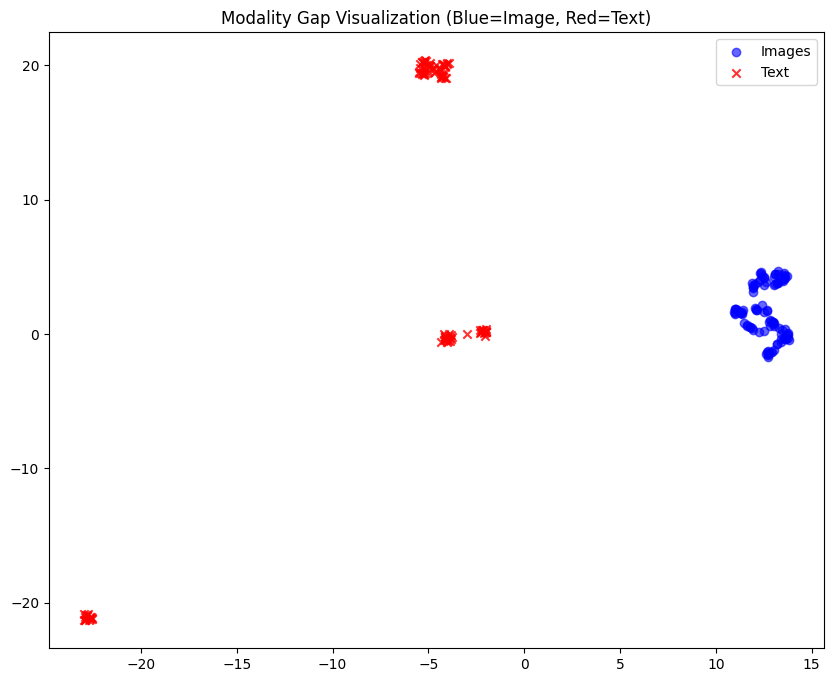

In [ ]:
import umap.umap_ as umap
import matplotlib.pyplot as plt

def get_embeddings(num_samples=100):
    subset_indices = list(range(num_samples))
    subset = Subset(dataset, subset_indices)
    loader = DataLoader(subset, batch_size=num_samples, shuffle=False)

    images, labels = next(iter(loader))
    images = images.to(device)

    text_labels = [f"a photo of a {class_names[l]}" for l in labels]
    text_inputs = torch.cat([clip.tokenize(t) for t in text_labels]).to(device)

    with torch.no_grad():
        img_emb = model.encode_image(images).cpu().numpy()
        txt_emb = model.encode_text(text_inputs).cpu().numpy()

    return img_emb, txt_emb, labels.numpy()

img_emb, txt_emb, labels = get_embeddings(100)

combined_emb = np.vstack((img_emb, txt_emb))
modality_labels = np.array([0]*len(img_emb) + [1]*len(txt_emb))
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, metric='cosine')
embedding_2d = reducer.fit_transform(combined_emb)

plt.figure(figsize=(10, 8))
plt.scatter(embedding_2d[modality_labels==0, 0], embedding_2d[modality_labels==0, 1], c='blue', label='Images', alpha=0.6)
plt.scatter(embedding_2d[modality_labels==1, 0], embedding_2d[modality_labels==1, 1], c='red', label='Text', marker='x', alpha=0.8)
plt.legend()
plt.title("Modality Gap Visualization (Blue=Image, Red=Text)")
plt.show()

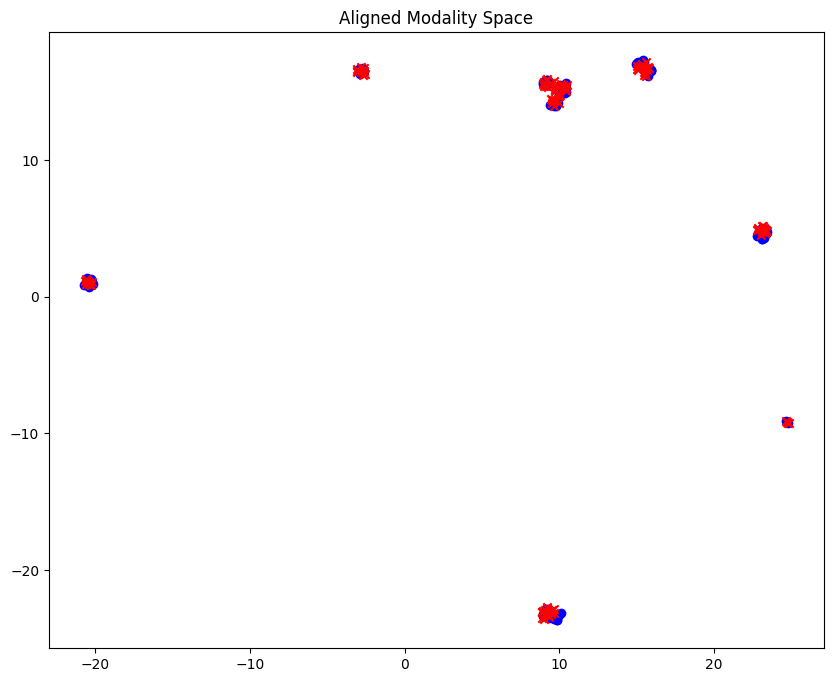

In [ ]:
from scipy.linalg import orthogonal_procrustes

img_emb_norm = img_emb / np.linalg.norm(img_emb, axis=1, keepdims=True)
txt_emb_norm = txt_emb / np.linalg.norm(txt_emb, axis=1, keepdims=True)

R, scale = orthogonal_procrustes(img_emb_norm, txt_emb_norm)
img_emb_aligned = img_emb_norm @ R

combined_aligned = np.vstack((img_emb_aligned, txt_emb_norm))
embedding_aligned_2d = reducer.fit_transform(combined_aligned)

plt.figure(figsize=(10, 8))
plt.scatter(embedding_aligned_2d[modality_labels==0, 0], embedding_aligned_2d[modality_labels==0, 1], c='blue', label='Aligned Images')
plt.scatter(embedding_aligned_2d[modality_labels==1, 0], embedding_aligned_2d[modality_labels==1, 1], c='red', label='Text', marker='x')
plt.title("Aligned Modality Space")
plt.show()


In [ ]:
def run_aligned_zero_shot(template_func, rotation_matrix):
    text_inputs = torch.cat([clip.tokenize(template_func(c)) for c in class_names]).to(device)

    with torch.no_grad():
        text_features = model.encode_text(text_inputs)
        text_features /= text_features.norm(dim=-1, keepdim=True)

    correct = 0
    total = 0

    R_tensor = torch.tensor(rotation_matrix, dtype=torch.float16 if device == 'cuda' else torch.float32).to(device)

    print("Running Aligned Evaluation...")
    for images, labels in tqdm(dataloader):
        images = images.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            image_features = model.encode_image(images)
            image_features /= image_features.norm(dim=-1, keepdim=True)
            image_features_aligned = image_features @ R_tensor
            similarity = (100.0 * image_features_aligned @ text_features.T).softmax(dim=-1)
            predictions = similarity.argmax(dim=-1)

        correct += (predictions == labels).sum().item()
        total += labels.size(0)

    return correct / total
aligned_acc = run_aligned_zero_shot(prompt_templates[1], R)

print(f"Baseline Accuracy: {run_zero_shot(prompt_templates[1]):.4f}")
print(f"Aligned Accuracy:  {aligned_acc:.4f}")

Running Aligned Evaluation...


100%|██████████| 250/250 [00:27<00:00,  9.14it/s]

Baseline Accuracy: 0.9736
Aligned Accuracy:  0.9744
